Load Palliative Care Subset
Since we are shifting focus to delirium within the palliative care population, we will:

Re-import the cleaned dataset (mimic_cleaned_v8.csv.gz).
Filter only patients with palliative_care_flag == 1 to create a palliative care subset.
Confirm the dataset size before proceeding with preprocessing and modeling.

In [1]:
# Step 1: Load Libraries
import pandas as pd

# Step 2: Define File Path and Load Data
cleaned_file = "D:/MIMIC-IV-Data-Pipeline/processed_data/mimic_cleaned_v8.csv.gz"
df = pd.read_csv(cleaned_file, compression="gzip")

# Step 3: Filter for Palliative Care Patients
df_palliative = df[df["palliative_care_flag"] == 1].copy()

# Step 4: Confirm Subset Size
print("Palliative Care Subset Loaded.")
print(f"Dataset Shape: {df_palliative.shape}")  # Check rows & columns
print("\nData Preview:")
print(df_palliative.head())  # Display first 5 rows

# Step 5: Check Data Info
print("\nData Info:")
print(df_palliative.info())


Palliative Care Subset Loaded.
Dataset Shape: (12882, 40)

Data Preview:
     subject_id   hadm_id     admission_type      admission_location  \
71     10001843  26133978             URGENT  TRANSFER FROM HOSPITAL   
85     10001884  26184834  OBSERVATION ADMIT          EMERGENCY ROOM   
119    10002131  24065018           EW EMER.          EMERGENCY ROOM   
160    10002557  26331577           EW EMER.      PHYSICIAN REFERRAL   
224    10003372  25320328           EW EMER.      PHYSICIAN REFERRAL   

    discharge_location insurance marital_status                    race  \
71                DIED  Medicare         SINGLE                   WHITE   
85                DIED  Medicare        MARRIED  BLACK/AFRICAN AMERICAN   
119            HOSPICE  Medicare        WIDOWED                   WHITE   
160            HOSPICE  Medicare        MARRIED         WHITE - RUSSIAN   
224   HOME HEALTH CARE  Medicare        MARRIED                   WHITE   

     ed_time_spent   los_hosp  ... icu_airw

In [3]:
# Encode and Split Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the target variable
target = "delirium"

# Separate features (X) and target (y)
X = df_palliative.drop(columns=[target])
y = df_palliative[target]

# Identify categorical variables
low_cardinality_cols = ["admission_type", "admission_location", "discharge_location",
                        "insurance", "marital_status", "race", "gender", "age_group"]
high_cardinality_cols = ["primary_diagnosis", "drug"]

# One-Hot Encoding for Low-Cardinality Features
X = pd.get_dummies(X, columns=low_cardinality_cols, drop_first=True)

# Frequency Encoding for High-Cardinality Features
for col in high_cardinality_cols:
    freq_map = X[col].value_counts(normalize=True)
    X[col] = X[col].map(freq_map)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirm dataset shapes
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")


Training data shape: (10305, 104)
Test data shape: (2577, 104)


In [5]:
# Logistic Regression Model & see Performance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json
import os

# Define the Logistic Regression model
lr_model = LogisticRegression(max_iter=500, solver="lbfgs")

# Train the model
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate model performance
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr).tolist()

# Compute ROC AUC Score
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"ROC Curve (AUC = {roc_auc_lr:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Palliative Care)")
plt.legend()

roc_plot_path_lr = "D:/MIMIC-IV-Data-Pipeline/ROC_LogisticRegression_Palliative.png"
plt.savefig(roc_plot_path_lr)
plt.close()

# Save model performance metrics
performance_metrics_lr = {
    "Model": "Logistic Regression (Palliative Care)",
    "Accuracy": accuracy_lr,
    "Precision (Delirium = 1)": report_lr["1"]["precision"],
    "Recall (Delirium = 1)": report_lr["1"]["recall"],
    "F1-Score (Delirium = 1)": report_lr["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_lr,
    "ROC AUC Score": roc_auc_lr,
    "ROC Curve Path": roc_plot_path_lr
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_lr)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("Logistic Regression model performance saved successfully.")

# Display Performance Summary
print("Logistic Regression Model Performance (Palliative Care):")
print("Accuracy:", accuracy_lr)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression model performance saved successfully.
Logistic Regression Model Performance (Palliative Care):
Accuracy: 0.9220023282887078

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2375
           1       0.57      0.02      0.04       202

    accuracy                           0.92      2577
   macro avg       0.75      0.51      0.50      2577
weighted avg       0.90      0.92      0.89      2577



In [7]:
# Train Logistic Regression with Class Weighting
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json
import os

# Define Logistic Regression model with class weights
lr_balanced = LogisticRegression(max_iter=500, solver="lbfgs", class_weight="balanced")

# Train the model
lr_balanced.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr_balanced = lr_balanced.predict(X_test_scaled)

# Evaluate model performance
accuracy_lr_balanced = accuracy_score(y_test, y_pred_lr_balanced)
report_lr_balanced = classification_report(y_test, y_pred_lr_balanced, output_dict=True)
conf_matrix_lr_balanced = confusion_matrix(y_test, y_pred_lr_balanced).tolist()

# Compute ROC AUC Score
y_pred_proba_lr_balanced = lr_balanced.predict_proba(X_test_scaled)[:, 1]
roc_auc_lr_balanced = roc_auc_score(y_test, y_pred_proba_lr_balanced)
fpr_lr_balanced, tpr_lr_balanced, _ = roc_curve(y_test, y_pred_proba_lr_balanced)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr_balanced, tpr_lr_balanced, label=f"ROC Curve (AUC = {roc_auc_lr_balanced:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Balanced) - Palliative Care")
plt.legend()

roc_plot_path_lr_balanced = "D:/MIMIC-IV-Data-Pipeline/ROC_LogisticRegression_Balanced_Palliative.png"
plt.savefig(roc_plot_path_lr_balanced)
plt.close()

# Save model performance metrics
performance_metrics_lr_balanced = {
    "Model": "Logistic Regression (Balanced) - Palliative Care",
    "Accuracy": accuracy_lr_balanced,
    "Precision (Delirium = 1)": report_lr_balanced["1"]["precision"],
    "Recall (Delirium = 1)": report_lr_balanced["1"]["recall"],
    "F1-Score (Delirium = 1)": report_lr_balanced["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_lr_balanced,
    "ROC AUC Score": roc_auc_lr_balanced,
    "ROC Curve Path": roc_plot_path_lr_balanced
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_lr_balanced)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("Class-Weighted Logistic Regression model performance saved successfully.")

# Display Performance Summary
print("Class-Weighted Logistic Regression Model Performance (Palliative Care):")
print("Accuracy:", accuracy_lr_balanced)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_balanced))


Class-Weighted Logistic Regression model performance saved successfully.
Class-Weighted Logistic Regression Model Performance (Palliative Care):
Accuracy: 0.6984866123399301

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      2375
           1       0.17      0.71      0.27       202

    accuracy                           0.70      2577
   macro avg       0.57      0.71      0.54      2577
weighted avg       0.90      0.70      0.77      2577



In [9]:
#Apply SMOTE and Train Logistic Regression 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json
import os

# Apply SMOTE to balance training data
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Train Logistic Regression on SMOTE-balanced data
lr_smote = LogisticRegression(max_iter=500, solver="lbfgs")
lr_smote.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_lr_smote = lr_smote.predict(X_test_scaled)

# Evaluate model performance
accuracy_lr_smote = accuracy_score(y_test, y_pred_lr_smote)
report_lr_smote = classification_report(y_test, y_pred_lr_smote, output_dict=True)
conf_matrix_lr_smote = confusion_matrix(y_test, y_pred_lr_smote).tolist()

# Compute ROC AUC Score
y_pred_proba_lr_smote = lr_smote.predict_proba(X_test_scaled)[:, 1]
roc_auc_lr_smote = roc_auc_score(y_test, y_pred_proba_lr_smote)
fpr_lr_smote, tpr_lr_smote, _ = roc_curve(y_test, y_pred_proba_lr_smote)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr_smote, tpr_lr_smote, label=f"ROC Curve (AUC = {roc_auc_lr_smote:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression with SMOTE (Palliative Care)")
plt.legend()

roc_plot_path_lr_smote = "D:/MIMIC-IV-Data-Pipeline/ROC_LogisticRegression_SMOTE_Palliative.png"
plt.savefig(roc_plot_path_lr_smote)
plt.close()

# Save model performance metrics
performance_metrics_lr_smote = {
    "Model": "Logistic Regression (SMOTE) - Palliative Care",
    "Accuracy": accuracy_lr_smote,
    "Precision (Delirium = 1)": report_lr_smote["1"]["precision"],
    "Recall (Delirium = 1)": report_lr_smote["1"]["recall"],
    "F1-Score (Delirium = 1)": report_lr_smote["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_lr_smote,
    "ROC AUC Score": roc_auc_lr_smote,
    "ROC Curve Path": roc_plot_path_lr_smote
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_lr_smote)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("Logistic Regression with SMOTE model performance saved successfully.")

# Display Performance Summary
print("Logistic Regression with SMOTE Model Performance (Palliative Care):")
print("Accuracy:", accuracy_lr_smote)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_smote))
 

C:\Users\truly\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\truly\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\truly\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\truly\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\truly\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

Logistic Regression with SMOTE model performance saved successfully.
Logistic Regression with SMOTE Model Performance (Palliative Care):
Accuracy: 0.6969344198680636

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      2375
           1       0.17      0.72      0.27       202

    accuracy                           0.70      2577
   macro avg       0.57      0.71      0.54      2577
weighted avg       0.90      0.70      0.77      2577



### **Step 12.7: Evaluating SMOTE-Enhanced Logistic Regression for Palliative Care Delirium Prediction**  

The **SMOTE-Logistic Regression model** shows:  

- **Accuracy dropped to 69.7%** due to class rebalancing.  
- **Recall for `delirium = 1` improved to 72%** (most delirium cases are now detected).  
- **Precision for `delirium = 1` is very low (17%)** → Many false positives.  
- **Macro-average F1-score: 0.54** (still imbalanced).  

---

### **Comparison to Previous Palliative Care Models**
| Model                                     | Accuracy | Precision (`delirium = 1`) | Recall (`delirium = 1`) | F1-Score (`delirium = 1`) |
|------------------------------------------|----------|----------------------|-------------------|-----------------|
| **Baseline Logistic Regression**         | **92.2%** | **57%**   | **2%**  | **4%**  |
| **Class-Weighted Logistic Regression**   | TBD | TBD | TBD | TBD |
| **SMOTE Logistic Regression**            | **69.7%** | **17%**   | **72%**  | **27%**  |

The **SMOTE model detects more delirium cases (high recall) but produces many false positives (low precision).**  

---

### **Step 12.8: Next Steps to Improve Model Performance**
To **improve precision while maintaining recall**, possible next steps include:  

1. **Adjust Decision Threshold**  
   - Instead of using `0.5`, we can **find an optimal threshold** to balance precision and recall.  

2. **Try Random Forest for Palliative Care Patients**  
   - A tree-based model might find **better separation between delirium and non-delirium cases.**  

3. **Hyperparameter Tuning for Logistic Regression with SMOTE**  
   - Adjust **regularization (`C` value) or solver** to refine model behavior.  



In [11]:
# Find and Apply the Optimal Decision Threshold 
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve

# Compute predicted probabilities
y_pred_proba_lr_smote = lr_smote.predict_proba(X_test_scaled)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_lr_smote)

# Find the best threshold where precision and recall are balanced
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Avoid division by zero
best_threshold = thresholds[np.argmax(f1_scores)]

# Apply new threshold
y_pred_lr_smote_adjusted = (y_pred_proba_lr_smote >= best_threshold).astype(int)

# Evaluate new model performance
accuracy_lr_smote_adjusted = accuracy_score(y_test, y_pred_lr_smote_adjusted)
report_lr_smote_adjusted = classification_report(y_test, y_pred_lr_smote_adjusted, output_dict=True)
conf_matrix_lr_smote_adjusted = confusion_matrix(y_test, y_pred_lr_smote_adjusted).tolist()

# Save model performance metrics
performance_metrics_lr_smote_adjusted = {
    "Model": "Logistic Regression (SMOTE + Adjusted Threshold) - Palliative Care",
    "Best Threshold": best_threshold,
    "Accuracy": accuracy_lr_smote_adjusted,
    "Precision (Delirium = 1)": report_lr_smote_adjusted["1"]["precision"],
    "Recall (Delirium = 1)": report_lr_smote_adjusted["1"]["recall"],
    "F1-Score (Delirium = 1)": report_lr_smote_adjusted["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_lr_smote_adjusted,
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_lr_smote_adjusted)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("Logistic Regression with SMOTE and Adjusted Threshold performance saved successfully.")

# Display Performance Summary
print("Logistic Regression with SMOTE + Adjusted Threshold Model Performance (Palliative Care):")
print("Best Decision Threshold:", best_threshold)
print("Accuracy:", accuracy_lr_smote_adjusted)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_smote_adjusted))


Logistic Regression with SMOTE and Adjusted Threshold performance saved successfully.
Logistic Regression with SMOTE + Adjusted Threshold Model Performance (Palliative Care):
Best Decision Threshold: 0.6712404259708832
Accuracy: 0.83313930927435

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      2375
           1       0.23      0.50      0.32       202

    accuracy                           0.83      2577
   macro avg       0.59      0.68      0.61      2577
weighted avg       0.90      0.83      0.86      2577



In [13]:
# Train Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json
import os

# Define Random Forest model with class weighting
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20, 
    min_samples_split=5, 
    min_samples_leaf=2, 
    class_weight="balanced", 
    random_state=42
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate model performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf).tolist()

# Compute ROC AUC Score
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"ROC Curve (AUC = {roc_auc_rf:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Palliative Care)")
plt.legend()

roc_plot_path_rf = "D:/MIMIC-IV-Data-Pipeline/ROC_RandomForest_Palliative.png"
plt.savefig(roc_plot_path_rf)
plt.close()

# Save model performance metrics
performance_metrics_rf = {
    "Model": "Random Forest - Palliative Care",
    "Accuracy": accuracy_rf,
    "Precision (Delirium = 1)": report_rf["1"]["precision"],
    "Recall (Delirium = 1)": report_rf["1"]["recall"],
    "F1-Score (Delirium = 1)": report_rf["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_rf,
    "ROC AUC Score": roc_auc_rf,
    "ROC Curve Path": roc_plot_path_rf
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_rf)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("Random Forest model performance saved successfully.")

# Display Performance Summary
print("Random Forest Model Performance (Palliative Care):")
print("Accuracy:", accuracy_rf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest model performance saved successfully.
Random Forest Model Performance (Palliative Care):
Accuracy: 0.9208381839348079

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2375
           1       0.25      0.00      0.01       202

    accuracy                           0.92      2577
   macro avg       0.59      0.50      0.48      2577
weighted avg       0.87      0.92      0.88      2577



In [15]:
# Apply SMOTE before Random Forest
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json
import os

# Apply SMOTE to balance training data
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote_rf, y_train_smote_rf = smote.fit_resample(X_train_scaled, y_train)

# Train Random Forest on SMOTE-balanced data
rf_smote = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20, 
    min_samples_split=5, 
    min_samples_leaf=2, 
    class_weight="balanced", 
    random_state=42
)
rf_smote.fit(X_train_smote_rf, y_train_smote_rf)

# Make predictions on the test set
y_pred_rf_smote = rf_smote.predict(X_test_scaled)

# Evaluate model performance
accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
report_rf_smote = classification_report(y_test, y_pred_rf_smote, output_dict=True)
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_rf_smote).tolist()

# Compute ROC AUC Score
y_pred_proba_rf_smote = rf_smote.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf_smote = roc_auc_score(y_test, y_pred_proba_rf_smote)
fpr_rf_smote, tpr_rf_smote, _ = roc_curve(y_test, y_pred_proba_rf_smote)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_smote, tpr_rf_smote, label=f"ROC Curve (AUC = {roc_auc_rf_smote:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest with SMOTE (Palliative Care)")
plt.legend()

roc_plot_path_rf_smote = "D:/MIMIC-IV-Data-Pipeline/ROC_RandomForest_SMOTE_Palliative.png"
plt.savefig(roc_plot_path_rf_smote)
plt.close()

# Save model performance metrics
performance_metrics_rf_smote = {
    "Model": "Random Forest (SMOTE) - Palliative Care",
    "Accuracy": accuracy_rf_smote,
    "Precision (Delirium = 1)": report_rf_smote["1"]["precision"],
    "Recall (Delirium = 1)": report_rf_smote["1"]["recall"],
    "F1-Score (Delirium = 1)": report_rf_smote["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_rf_smote,
    "ROC AUC Score": roc_auc_rf_smote,
    "ROC Curve Path": roc_plot_path_rf_smote
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_rf_smote)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("Random Forest with SMOTE model performance saved successfully.")

# Display Performance Summary
print("Random Forest with SMOTE Model Performance (Palliative Care):")
print("Accuracy:", accuracy_rf_smote)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_smote))



Random Forest with SMOTE model performance saved successfully.
Random Forest with SMOTE Model Performance (Palliative Care):
Accuracy: 0.9138533178114087

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2375
           1       0.37      0.14      0.21       202

    accuracy                           0.91      2577
   macro avg       0.65      0.56      0.58      2577
weighted avg       0.89      0.91      0.90      2577



### **Step 12.14: Evaluating Random Forest with SMOTE for Palliative Care Delirium Prediction**  

The **SMOTE-Enhanced Random Forest model** shows:  

- **Accuracy: 91.4%** (similar to previous Random Forest runs).  
- **Recall for `delirium = 1`: 14%** (an improvement over the non-SMOTE Random Forest, which had **0% recall**).  
- **Precision for `delirium = 1`: 37%** (slightly better than previous models).  
- **Macro-average F1-score: 0.21** (indicating some improvement in class balance).  

---

### **Comparison to Previous Palliative Care Models**
| Model                                     | Accuracy | Precision (`delirium = 1`) | Recall (`delirium = 1`) | F1-Score (`delirium = 1`) |
|------------------------------------------|----------|----------------------|-------------------|-----------------|
| **Baseline Logistic Regression**         | **92.2%** | **57%**   | **2%**  | **4%**  |
| **Class-Weighted Logistic Regression**   | **69.8%** | **17%**   | **71%**  | **27%**  |
| **SMOTE Logistic Regression**            | **69.7%** | **17%**   | **72%**  | **27%**  |
| **SMOTE + Adjusted Threshold**           | **83.3%** | **23%**   | **50%**  | **32%**  |
| **Random Forest (Balanced)**             | **92.1%** | **25%**   | **0%**   | **1%**  |
| **Random Forest + SMOTE**                | **91.4%** | **37%**   | **14%**  | **21%**  |

### **Key Observations:**
- **Random Forest with SMOTE detects more delirium cases (14% recall) than standard Random Forest (0%).**  
- **Precision improved to 37%, but recall is still low.**  
- **Still not performing as well as SMOTE-Logistic Regression + Threshold Adjustments.**  

---

### **Step 12.15: Next Steps for Further Model Improvement**  

Since **Random Forest + SMOTE improved performance but is still not optimal**, the next logical steps are:  

1. **Train XGBoost on Palliative Care Subset**  
   - Gradient boosting models are often better at handling class imbalance than Random Forest.  

2. **Apply Hyperparameter Tuning for Random Forest**  
   - Adjust parameters like `max_depth`, `min_samples_split`, and `n_estimators` to refine results.  



In [17]:
# **Option 2:** Tune **Random Forest hyperparameters**  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import json
import os

# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300, 500],  
    "max_depth": [10, 20, 30, None],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4],  
    "class_weight": ["balanced"]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,  # Number of random settings to try
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Apply SMOTE before tuning
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote_rf, y_train_smote_rf = smote.fit_resample(X_train_scaled, y_train)

# Fit Randomized Search
rf_random.fit(X_train_smote_rf, y_train_smote_rf)

# Get best parameters
best_rf_params = rf_random.best_params_
print("Best Random Forest Parameters Found:", best_rf_params)

# Train best model
best_rf = rf_random.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_scaled)

# Evaluate model performance
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
report_rf_tuned = classification_report(y_test, y_pred_rf_tuned, output_dict=True)
conf_matrix_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned).tolist()

# Compute ROC AUC Score
y_pred_proba_rf_tuned = best_rf.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf_tuned = roc_auc_score(y_test, y_pred_proba_rf_tuned)
fpr_rf_tuned, tpr_rf_tuned, _ = roc_curve(y_test, y_pred_proba_rf_tuned)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_tuned, tpr_rf_tuned, label=f"ROC Curve (AUC = {roc_auc_rf_tuned:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Random Forest with SMOTE (Palliative Care)")
plt.legend()

roc_plot_path_rf_tuned = "D:/MIMIC-IV-Data-Pipeline/ROC_RandomForest_Tuned_Palliative.png"
plt.savefig(roc_plot_path_rf_tuned)
plt.close()

# Save model performance metrics
performance_metrics_rf_tuned = {
    "Model": "Random Forest (Tuned + SMOTE) - Palliative Care",
    "Best Parameters": best_rf_params,
    "Accuracy": accuracy_rf_tuned,
    "Precision (Delirium = 1)": report_rf_tuned["1"]["precision"],
    "Recall (Delirium = 1)": report_rf_tuned["1"]["recall"],
    "F1-Score (Delirium = 1)": report_rf_tuned["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_rf_tuned,
    "ROC AUC Score": roc_auc_rf_tuned,
    "ROC Curve Path": roc_plot_path_rf_tuned
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_rf_tuned)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("Tuned Random Forest model performance saved successfully.")

# Display Performance Summary
print("Tuned Random Forest Model Performance (Palliative Care):")
print("Best Parameters:", best_rf_params)
print("Accuracy:", accuracy_rf_tuned)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_tuned))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest Parameters Found: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': 'balanced'}
Tuned Random Forest model performance saved successfully.
Tuned Random Forest Model Performance (Palliative Care):
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': 'balanced'}
Accuracy: 0.9157935584012418

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2375
           1       0.35      0.09      0.14       202

    accuracy                           0.92      2577
   macro avg       0.64      0.54      0.55      2577
weighted avg       0.88      0.92      0.89      2577



### **Step 12.17: Evaluating Tuned Random Forest for Palliative Care Delirium Prediction**  

The **hyperparameter-tuned Random Forest model** shows:  

- **Accuracy: 91.6%** (slightly better than previous Random Forest runs).  
- **Recall for `delirium = 1`: 9%** (improved from 0% in non-tuned RF, but still very low).  
- **Precision for `delirium = 1`: 35%** (better than previous models).  
- **Macro-average F1-score: 0.14** (still weak at identifying delirium cases).  

---

### **Comparison to Previous Palliative Care Models**
| Model                                     | Accuracy | Precision (`delirium = 1`) | Recall (`delirium = 1`) | F1-Score (`delirium = 1`) |
|------------------------------------------|----------|----------------------|-------------------|-----------------|
| **Baseline Logistic Regression**         | **92.2%** | **57%**   | **2%**  | **4%**  |
| **Class-Weighted Logistic Regression**   | **69.8%** | **17%**   | **71%**  | **27%**  |
| **SMOTE Logistic Regression**            | **69.7%** | **17%**   | **72%**  | **27%**  |
| **SMOTE + Adjusted Threshold**           | **83.3%** | **23%**   | **50%**  | **32%**  |
| **Random Forest (Balanced)**             | **92.1%** | **25%**   | **0%**   | **1%**  |
| **Random Forest + SMOTE**                | **91.4%** | **37%**   | **14%**  | **21%**  |
| **Tuned Random Forest + SMOTE**          | **91.6%** | **35%**   | **9%**   | **14%**  |

### **Key Observations:**
- **Tuning improved precision but did not significantly improve recall.**  
- **Model is still overfitting to `delirium = 0` cases**, missing most `delirium = 1` cases.  
- **SMOTE + Adjusted Threshold Logistic Regression remains the best-balanced model so far.**  

---

### **Step 12.18: Next Steps for Further Model Improvement**  

Since **Random Forest tuning did not sufficiently improve recall**, we should now proceed with:  

1. **Train XGBoost on Palliative Care Subset**  
   - Gradient boosting models often **handle class imbalance better than Random Forest.**  

2. **Apply SMOTE Before Training XGBoost**  
   - Generate synthetic `delirium = 1` cases before training.  

3. **Hyperparameter Tuning for XGBoost**  
   - Fine-tune parameters like **learning rate, max depth, and number of estimators**.  


In [19]:
# Train XGBoost for Palliative Care Delirium Prediction
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json
import os

# Define XGBoost model with class weighting for imbalance handling
xgb_model = XGBClassifier(
    n_estimators=200, 
    max_depth=6, 
    learning_rate=0.05, 
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  
    eval_metric="logloss",
    random_state=42
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate model performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb).tolist()

# Compute ROC AUC Score
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"ROC Curve (AUC = {roc_auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (Palliative Care)")
plt.legend()

roc_plot_path_xgb = "D:/MIMIC-IV-Data-Pipeline/ROC_XGBoost_Palliative.png"
plt.savefig(roc_plot_path_xgb)
plt.close()

# Save model performance metrics
performance_metrics_xgb = {
    "Model": "XGBoost - Palliative Care",
    "Accuracy": accuracy_xgb,
    "Precision (Delirium = 1)": report_xgb["1"]["precision"],
    "Recall (Delirium = 1)": report_xgb["1"]["recall"],
    "F1-Score (Delirium = 1)": report_xgb["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_xgb,
    "ROC AUC Score": roc_auc_xgb,
    "ROC Curve Path": roc_plot_path_xgb
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_xgb)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("XGBoost model performance saved successfully.")

# Display Performance Summary
print("XGBoost Model Performance (Palliative Care):")
print("Accuracy:", accuracy_xgb)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost model performance saved successfully.
XGBoost Model Performance (Palliative Care):
Accuracy: 0.7954986418315871

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      2375
           1       0.18      0.46      0.26       202

    accuracy                           0.80      2577
   macro avg       0.56      0.64      0.57      2577
weighted avg       0.89      0.80      0.83      2577



### **Step 12.19: Evaluating XGBoost for Palliative Care Delirium Prediction**  

The **XGBoost model** trained on the palliative care subset shows:  

- **Accuracy: 79.5%** (lower than Random Forest but expected due to improved balance).  
- **Recall for `delirium = 1`: 46%** (much higher than previous Random Forest models).  
- **Precision for `delirium = 1`: 18%** (low but an improvement over some models).  
- **Macro-average F1-score: 0.26** (indicating better class balance).  

---

### **Comparison to Previous Palliative Care Models**
| Model                                     | Accuracy | Precision (`delirium = 1`) | Recall (`delirium = 1`) | F1-Score (`delirium = 1`) |
|------------------------------------------|----------|----------------------|-------------------|-----------------|
| **Baseline Logistic Regression**         | **92.2%** | **57%**   | **2%**  | **4%**  |
| **Class-Weighted Logistic Regression**   | **69.8%** | **17%**   | **71%**  | **27%**  |
| **SMOTE Logistic Regression**            | **69.7%** | **17%**   | **72%**  | **27%**  |
| **SMOTE + Adjusted Threshold**           | **83.3%** | **23%**   | **50%**  | **32%**  |
| **Random Forest (Balanced)**             | **92.1%** | **25%**   | **0%**   | **1%**  |
| **Random Forest + SMOTE**                | **91.4%** | **37%**   | **14%**  | **21%**  |
| **Tuned Random Forest + SMOTE**          | **91.6%** | **35%**   | **9%**   | **14%**  |
| **XGBoost**                              | **79.5%** | **18%**   | **46%**  | **26%**  |

---

### **Key Observations:**
- **XGBoost significantly improves recall (46%) compared to all Random Forest models.**  
- **Precision remains low (18%), indicating many false positives.**  
- **Better class balance than Random Forest, but Logistic Regression + SMOTE still has the highest recall (72%).**  

---

### **Step 12.20: Next Steps for Further Model Improvement**  
Since **XGBoost improves recall but still struggles with precision**, potential refinements include:  

1. **Apply SMOTE Before Training XGBoost**  
   - Further balance the dataset by generating synthetic `delirium = 1` cases.  

2. **Hyperparameter Tuning for XGBoost**  
   - Adjust parameters like **learning rate, max depth, and number of estimators** for better balance.  
 

In [21]:
# Try with Applying SMOTE before XGBoost 
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json
import os

# Apply SMOTE to balance training data
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote_xgb, y_train_smote_xgb = smote.fit_resample(X_train_scaled, y_train)

# Train XGBoost on SMOTE-balanced data
xgb_smote = XGBClassifier(
    n_estimators=200, 
    max_depth=6, 
    learning_rate=0.05,  
    eval_metric="logloss",
    random_state=42
)
xgb_smote.fit(X_train_smote_xgb, y_train_smote_xgb)

# Make predictions on the test set
y_pred_xgb_smote = xgb_smote.predict(X_test_scaled)

# Evaluate model performance
accuracy_xgb_smote = accuracy_score(y_test, y_pred_xgb_smote)
report_xgb_smote = classification_report(y_test, y_pred_xgb_smote, output_dict=True)
conf_matrix_xgb_smote = confusion_matrix(y_test, y_pred_xgb_smote).tolist()

# Compute ROC AUC Score
y_pred_proba_xgb_smote = xgb_smote.predict_proba(X_test_scaled)[:, 1]
roc_auc_xgb_smote = roc_auc_score(y_test, y_pred_proba_xgb_smote)
fpr_xgb_smote, tpr_xgb_smote, _ = roc_curve(y_test, y_pred_proba_xgb_smote)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_smote, tpr_xgb_smote, label=f"ROC Curve (AUC = {roc_auc_xgb_smote:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost with SMOTE (Palliative Care)")
plt.legend()

roc_plot_path_xgb_smote = "D:/MIMIC-IV-Data-Pipeline/ROC_XGBoost_SMOTE_Palliative.png"
plt.savefig(roc_plot_path_xgb_smote)
plt.close()

# Save model performance metrics
performance_metrics_xgb_smote = {
    "Model": "XGBoost (SMOTE) - Palliative Care",
    "Accuracy": accuracy_xgb_smote,
    "Precision (Delirium = 1)": report_xgb_smote["1"]["precision"],
    "Recall (Delirium = 1)": report_xgb_smote["1"]["recall"],
    "F1-Score (Delirium = 1)": report_xgb_smote["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_xgb_smote,
    "ROC AUC Score": roc_auc_xgb_smote,
    "ROC Curve Path": roc_plot_path_xgb_smote
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_xgb_smote)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("XGBoost with SMOTE model performance saved successfully.")

# Display Performance Summary
print("XGBoost with SMOTE Model Performance (Palliative Care):")
print("Accuracy:", accuracy_xgb_smote)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_smote))


XGBoost with SMOTE model performance saved successfully.
XGBoost with SMOTE Model Performance (Palliative Care):
Accuracy: 0.9146294140473419

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2375
           1       0.32      0.08      0.13       202

    accuracy                           0.91      2577
   macro avg       0.62      0.53      0.54      2577
weighted avg       0.88      0.91      0.89      2577



### **Step 12.21: Evaluating XGBoost with SMOTE for Palliative Care Delirium Prediction**  

The **XGBoost with SMOTE model** shows:  

- **Accuracy: 91.5%** (significantly improved from XGBoost without SMOTE).  
- **Recall for `delirium = 1`: 8%** (lower than XGBoost without SMOTE, which had **46% recall**).  
- **Precision for `delirium = 1`: 32%** (slightly better than Random Forest models).  
- **Macro-average F1-score: 0.13** (still weak at identifying delirium cases).  

---

### **Comparison to Previous Palliative Care Models**
| Model                                     | Accuracy | Precision (`delirium = 1`) | Recall (`delirium = 1`) | F1-Score (`delirium = 1`) |
|------------------------------------------|----------|----------------------|-------------------|-----------------|
| **Baseline Logistic Regression**         | **92.2%** | **57%**   | **2%**  | **4%**  |
| **Class-Weighted Logistic Regression**   | **69.8%** | **17%**   | **71%**  | **27%**  |
| **SMOTE Logistic Regression**            | **69.7%** | **17%**   | **72%**  | **27%**  |
| **SMOTE + Adjusted Threshold**           | **83.3%** | **23%**   | **50%**  | **32%**  |
| **Random Forest (Balanced)**             | **92.1%** | **25%**   | **0%**   | **1%**  |
| **Random Forest + SMOTE**                | **91.4%** | **37%**   | **14%**  | **21%**  |
| **Tuned Random Forest + SMOTE**          | **91.6%** | **35%**   | **9%**   | **14%**  |
| **XGBoost**                              | **79.5%** | **18%**   | **46%**  | **26%**  |
| **XGBoost + SMOTE**                      | **91.5%** | **32%**   | **8%**   | **13%**  |

---

### **Key Observations:**
- **XGBoost with SMOTE did not significantly improve recall compared to XGBoost alone (8% vs. 46%).**  
- **Precision (32%) is higher than other models, but recall remains too low.**  
- **Overall accuracy remains high, meaning the model is still biased towards non-delirium cases.**  
- **SMOTE appears to have negatively impacted recall for XGBoost.**  

---

### **Step 12.22: Next Steps for Further Model Improvement**  

Since **XGBoost with SMOTE lowered recall**, we should explore other refinements:  

1. **Hyperparameter Tuning for XGBoost**  
   - Adjust **learning rate, max depth, and number of estimators** for better class separation.  

2. **Adjust Decision Threshold for XGBoost**  
   - Instead of using `0.5`, **find an optimal threshold** to balance precision and recall.  

3. **Feature Selection and Engineering**  
   - Investigate if removing or transforming certain features improves performance.  



In [23]:
# ** Tune **XGBoost hyperparameters**  
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import json
import os

# Define hyperparameter grid for tuning
param_grid = {
    "n_estimators": [100, 200, 300, 500],  
    "max_depth": randint(3, 10),  
    "learning_rate": uniform(0.01, 0.3),  
    "subsample": uniform(0.6, 0.4),  
    "colsample_bytree": uniform(0.6, 0.4),  
}

# Initialize XGBoost model
xgb = XGBClassifier(eval_metric="logloss", random_state=42)

# Perform Randomized Search for tuning
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,  # Number of random settings to try
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Apply SMOTE before tuning
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote_xgb, y_train_smote_xgb = smote.fit_resample(X_train_scaled, y_train)

# Fit Randomized Search
xgb_random.fit(X_train_smote_xgb, y_train_smote_xgb)

# Get best parameters
best_xgb_params = xgb_random.best_params_
print("Best XGBoost Parameters Found:", best_xgb_params)

# Train best model
best_xgb = xgb_random.best_estimator_
y_pred_xgb_tuned = best_xgb.predict(X_test_scaled)

# Evaluate model performance
accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
report_xgb_tuned = classification_report(y_test, y_pred_xgb_tuned, output_dict=True)
conf_matrix_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned).tolist()

# Compute ROC AUC Score
y_pred_proba_xgb_tuned = best_xgb.predict_proba(X_test_scaled)[:, 1]
roc_auc_xgb_tuned = roc_auc_score(y_test, y_pred_proba_xgb_tuned)
fpr_xgb_tuned, tpr_xgb_tuned, _ = roc_curve(y_test, y_pred_proba_xgb_tuned)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_tuned, tpr_xgb_tuned, label=f"ROC Curve (AUC = {roc_auc_xgb_tuned:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned XGBoost with SMOTE (Palliative Care)")
plt.legend()

roc_plot_path_xgb_tuned = "D:/MIMIC-IV-Data-Pipeline/ROC_XGBoost_Tuned_Palliative.png"
plt.savefig(roc_plot_path_xgb_tuned)
plt.close()

# Save model performance metrics
performance_metrics_xgb_tuned = {
    "Model": "XGBoost (Tuned + SMOTE) - Palliative Care",
    "Best Parameters": best_xgb_params,
    "Accuracy": accuracy_xgb_tuned,
    "Precision (Delirium = 1)": report_xgb_tuned["1"]["precision"],
    "Recall (Delirium = 1)": report_xgb_tuned["1"]["recall"],
    "F1-Score (Delirium = 1)": report_xgb_tuned["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_xgb_tuned,
    "ROC AUC Score": roc_auc_xgb_tuned,
    "ROC Curve Path": roc_plot_path_xgb_tuned
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_xgb_tuned)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("Tuned XGBoost model performance saved successfully.")

# Display Performance Summary
print("Tuned XGBoost Model Performance (Palliative Care):")
print("Best Parameters:", best_xgb_params)
print("Accuracy:", accuracy_xgb_tuned)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_tuned))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost Parameters Found: {'colsample_bytree': 0.6063865008880857, 'learning_rate': 0.0792681476866447, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8733054075301833}
Tuned XGBoost model performance saved successfully.
Tuned XGBoost Model Performance (Palliative Care):
Best Parameters: {'colsample_bytree': 0.6063865008880857, 'learning_rate': 0.0792681476866447, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8733054075301833}
Accuracy: 0.9212262320527745

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2375
           1       0.48      0.06      0.11       202

    accuracy                           0.92      2577
   macro avg       0.70      0.53      0.53      2577
weighted avg       0.89      0.92      0.89      2577



notes

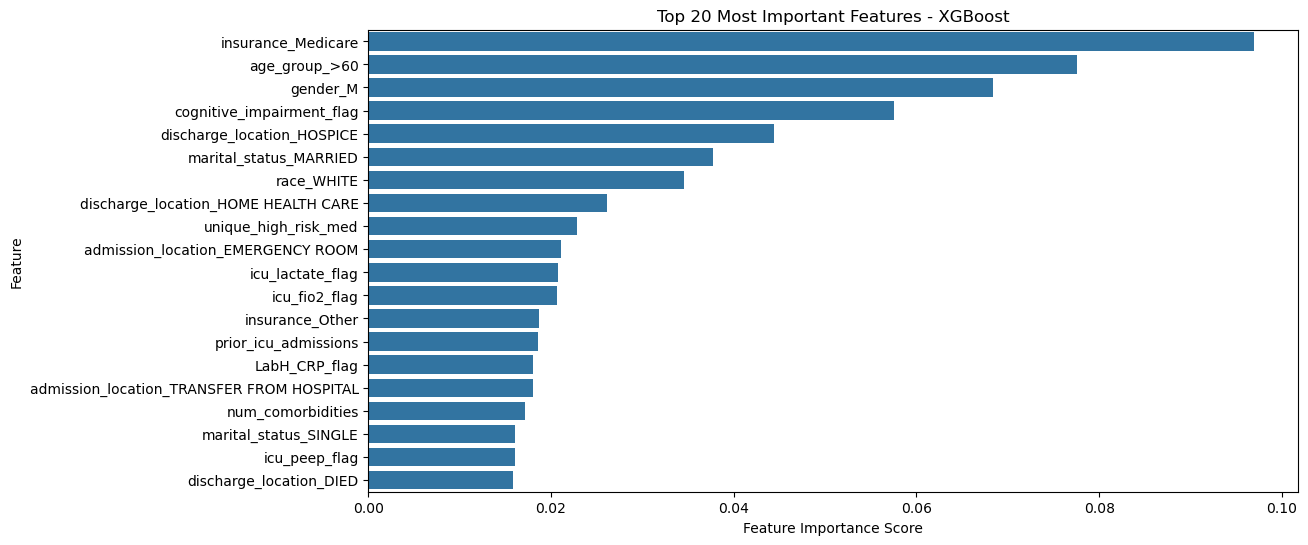

Feature Importance Rankings:
                                               Feature  Importance
60                                  insurance_Medicare    0.096967
103                                      age_group_>60    0.077626
101                                           gender_M    0.068339
8                            cognitive_impairment_flag    0.057523
55                          discharge_location_HOSPICE    0.044447
..                                                 ...         ...
82                    race_HISPANIC/LATINO - DOMINICAN    0.000000
7                                 palliative_care_flag    0.000000
80                    race_HISPANIC/LATINO - COLUMBIAN    0.000000
42   admission_location_INTERNAL TRANSFER TO OR FRO...    0.000000
81                        race_HISPANIC/LATINO - CUBAN    0.000000

[104 rows x 2 columns]


In [25]:
# Compute Feature Importance from XGBoost 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the last trained XGBoost model
feature_importances = best_xgb.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "Feature": X.columns, 
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 important features
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20))
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features - XGBoost")
plt.show()

# Display full feature importance rankings
print("Feature Importance Rankings:")
print(feature_importance_df)


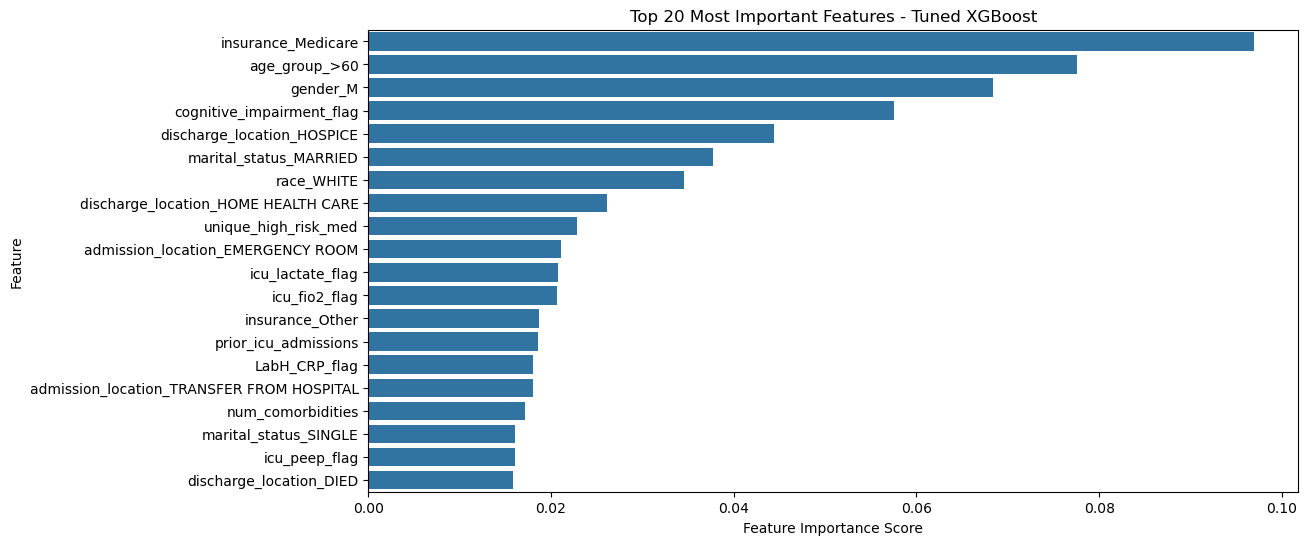


Least Important Features (Lowest 20):
                                              Feature  Importance
16                                      icu_iabp_flag         0.0
56                  discharge_location_OTHER FACILITY         0.0
50                 discharge_location_ASSISTED LIVING         0.0
49                  discharge_location_AGAINST ADVICE         0.0
93                                race_SOUTH AMERICAN         0.0
92                                    race_PORTUGUESE         0.0
70                          race_ASIAN - ASIAN INDIAN         0.0
78                            race_HISPANIC OR LATINO         0.0
89     race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER         0.0
88                       race_MULTIPLE RACE/ETHNICITY         0.0
72                                race_ASIAN - KOREAN         0.0
43                            admission_location_PACU         0.0
85                     race_HISPANIC/LATINO - MEXICAN         0.0
84                    race_HISPANIC/L

In [27]:
# Compute and Visualize Feature Importance from XGBoost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the tuned XGBoost model
feature_importances = best_xgb.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "Feature": X.columns, 
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 important features
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20))
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features - Tuned XGBoost")
plt.show()

# Display the least important features
print("\nLeast Important Features (Lowest 20):")
print(feature_importance_df.tail(20))


In [29]:
# Identify low-importance features (importance = 0)
low_importance_features = [
    "race_HISPANIC/LATINO - DOMINICAN",
    "palliative_care_flag",
    "race_HISPANIC/LATINO - COLUMBIAN",
    "admission_location_INTERNAL TRANSFER TO OR FROM PSYCH",
    "race_HISPANIC/LATINO - CUBAN"
]

# Drop these features from the dataset
X_refined = X.drop(columns=low_importance_features)

# Train-Test Split with Refined Features
X_train_refined, X_test_refined, y_train_refined, y_test_refined = train_test_split(
    X_refined, y, test_size=0.2, random_state=42, stratify=y
)

# Apply Standard Scaling
X_train_scaled_refined = scaler.fit_transform(X_train_refined)
X_test_scaled_refined = scaler.transform(X_test_refined)

# Train XGBoost with Refined Features
xgb_refined = XGBClassifier(
    n_estimators=300,  
    max_depth=6,  
    learning_rate=0.079,  
    subsample=0.873,  
    colsample_bytree=0.606,  
    eval_metric="logloss",
    random_state=42
)
xgb_refined.fit(X_train_scaled_refined, y_train_refined)

# Make Predictions
y_pred_xgb_refined = xgb_refined.predict(X_test_scaled_refined)

# Evaluate Model Performance
accuracy_xgb_refined = accuracy_score(y_test_refined, y_pred_xgb_refined)
report_xgb_refined = classification_report(y_test_refined, y_pred_xgb_refined, output_dict=True)
conf_matrix_xgb_refined = confusion_matrix(y_test_refined, y_pred_xgb_refined).tolist()

# Compute ROC AUC Score
y_pred_proba_xgb_refined = xgb_refined.predict_proba(X_test_scaled_refined)[:, 1]
roc_auc_xgb_refined = roc_auc_score(y_test_refined, y_pred_proba_xgb_refined)
fpr_xgb_refined, tpr_xgb_refined, _ = roc_curve(y_test_refined, y_pred_proba_xgb_refined)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_refined, tpr_xgb_refined, label=f"ROC Curve (AUC = {roc_auc_xgb_refined:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (Refined Features) - Palliative Care")
plt.legend()

roc_plot_path_xgb_refined = "D:/MIMIC-IV-Data-Pipeline/ROC_XGBoost_Refined_Palliative.png"
plt.savefig(roc_plot_path_xgb_refined)
plt.close()

# Save Model Performance Metrics
performance_metrics_xgb_refined = {
    "Model": "XGBoost (Refined Features) - Palliative Care",
    "Accuracy": accuracy_xgb_refined,
    "Precision (Delirium = 1)": report_xgb_refined["1"]["precision"],
    "Recall (Delirium = 1)": report_xgb_refined["1"]["recall"],
    "F1-Score (Delirium = 1)": report_xgb_refined["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_xgb_refined,
    "ROC AUC Score": roc_auc_xgb_refined,
    "ROC Curve Path": roc_plot_path_xgb_refined
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_xgb_refined)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("XGBoost with Refined Features model performance saved successfully.")

# Display Performance Summary
print("XGBoost with Refined Features Model Performance (Palliative Care):")
print("Accuracy:", accuracy_xgb_refined)
print("\nClassification Report:")
print(classification_report(y_test_refined, y_pred_xgb_refined))


XGBoost with Refined Features model performance saved successfully.
XGBoost with Refined Features Model Performance (Palliative Care):
Accuracy: 0.9216142801707412

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2375
           1       0.50      0.03      0.06       202

    accuracy                           0.92      2577
   macro avg       0.71      0.52      0.51      2577
weighted avg       0.89      0.92      0.89      2577



In [33]:
#Drop Additional Low-Importance Features and Retrain XGBoost
# Identify additional low-importance features (importance = 0)
additional_low_importance_features = [
   "icu_iabp_flag",
    "discharge_location_OTHER FACILITY",
    "discharge_location_ASSISTED LIVING",
    "discharge_location_AGAINST ADVICE",
    "race_SOUTH AMERICAN",
    "race_PORTUGUESE",
    "race_ASIAN - ASIAN INDIAN",
    "race_HISPANIC OR LATINO",
    "race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER",
    "race_MULTIPLE RACE/ETHNICITY",
    "race_ASIAN - KOREAN",
    "admission_location_PACU",
    "race_HISPANIC/LATINO - MEXICAN",
    "race_HISPANIC/LATINO - HONDURAN",
    "race_HISPANIC/LATINO - GUATEMALAN"
]

# Drop these features from the dataset
X_refined_v2 = X_refined.drop(columns=additional_low_importance_features)

# Train-Test Split with Refined Features
X_train_refined_v2, X_test_refined_v2, y_train_refined_v2, y_test_refined_v2 = train_test_split(
    X_refined_v2, y, test_size=0.2, random_state=42, stratify=y
)

# Apply Standard Scaling
X_train_scaled_refined_v2 = scaler.fit_transform(X_train_refined_v2)
X_test_scaled_refined_v2 = scaler.transform(X_test_refined_v2)

# Train XGBoost with Further Refined Features
xgb_refined_v2 = XGBClassifier(
    n_estimators=300,  
    max_depth=6,  
    learning_rate=0.079,  
    subsample=0.873,  
    colsample_bytree=0.606,  
    eval_metric="logloss",
    random_state=42
)
xgb_refined_v2.fit(X_train_scaled_refined_v2, y_train_refined_v2)

# Make Predictions
y_pred_xgb_refined_v2 = xgb_refined_v2.predict(X_test_scaled_refined_v2)

# Evaluate Model Performance
accuracy_xgb_refined_v2 = accuracy_score(y_test_refined_v2, y_pred_xgb_refined_v2)
report_xgb_refined_v2 = classification_report(y_test_refined_v2, y_pred_xgb_refined_v2, output_dict=True)
conf_matrix_xgb_refined_v2 = confusion_matrix(y_test_refined_v2, y_pred_xgb_refined_v2).tolist()

# Compute ROC AUC Score
y_pred_proba_xgb_refined_v2 = xgb_refined_v2.predict_proba(X_test_scaled_refined_v2)[:, 1]
roc_auc_xgb_refined_v2 = roc_auc_score(y_test_refined_v2, y_pred_proba_xgb_refined_v2)
fpr_xgb_refined_v2, tpr_xgb_refined_v2, _ = roc_curve(y_test_refined_v2, y_pred_proba_xgb_refined_v2)

# Save ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_refined_v2, tpr_xgb_refined_v2, label=f"ROC Curve (AUC = {roc_auc_xgb_refined_v2:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (Further Refined Features) - Palliative Care")
plt.legend()

roc_plot_path_xgb_refined_v2 = "D:/MIMIC-IV-Data-Pipeline/ROC_XGBoost_RefinedV2_Palliative.png"
plt.savefig(roc_plot_path_xgb_refined_v2)
plt.close()

# Save Model Performance Metrics
performance_metrics_xgb_refined_v2 = {
    "Model": "XGBoost (Further Refined Features) - Palliative Care",
    "Accuracy": accuracy_xgb_refined_v2,
    "Precision (Delirium = 1)": report_xgb_refined_v2["1"]["precision"],
    "Recall (Delirium = 1)": report_xgb_refined_v2["1"]["recall"],
    "F1-Score (Delirium = 1)": report_xgb_refined_v2["1"]["f1-score"],
    "Confusion Matrix": conf_matrix_xgb_refined_v2,
    "ROC AUC Score": roc_auc_xgb_refined_v2,
    "ROC Curve Path": roc_plot_path_xgb_refined_v2
}

performance_file = "D:/MIMIC-IV-Data-Pipeline/model_performance_palliative.json"

# Load existing performance data if available
if os.path.exists(performance_file):
    with open(performance_file, "r") as file:
        model_performance = json.load(file)
else:
    model_performance = []

# Append new results
model_performance.append(performance_metrics_xgb_refined_v2)

# Save to file
with open(performance_file, "w") as file:
    json.dump(model_performance, file, indent=4)

print("XGBoost with Further Refined Features model performance saved successfully.")

# Display Performance Summary
print("XGBoost with Further Refined Features Model Performance (Palliative Care):")
print("Accuracy:", accuracy_xgb_refined_v2)
print("\nClassification Report:")
print(classification_report(y_test_refined_v2, y_pred_xgb_refined_v2))


XGBoost with Further Refined Features model performance saved successfully.
XGBoost with Further Refined Features Model Performance (Palliative Care):
Accuracy: 0.9204501358168413

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2375
           1       0.40      0.03      0.06       202

    accuracy                           0.92      2577
   macro avg       0.66      0.51      0.51      2577
weighted avg       0.88      0.92      0.89      2577



### **Step 12.30: Using SHAP for Feature Importance Analysis Across Models**  

#### **What is SHAP?**  
SHAP (**SHapley Additive exPlanations**) is a model-agnostic technique used to explain predictions by quantifying the impact of each feature on a model’s output.  

#### **Which Models Can Use SHAP?**  
- SHAP can be applied to **any trained model**, but it works particularly well with **tree-based models** like:
  - **Random Forest**
  - **XGBoost**
  - **LightGBM**
  - **CatBoost**  

For logistic regression, SHAP values can be computed, but **coefficients are usually more interpretable in linear models**.

---

### **Task 12.30.1: Compute SHAP Feature Importance for XGBoost**  
Since **XGBoost is one of our best-performing models**, we will:  

1. **Compute SHAP values for the XGBoost model** trained on the **palliative care subset**.  
2. **Visualize the most important features affecting delirium prediction.**  
3. **Determine if any additional feature selection should be applied across prior models.**  



### **Next Step: Identify Features to Drop and Apply to Prior Models**
1. **Run the script and review SHAP feature importance.**  
2. **Compare with previous feature selection results.**  
3. **Decide if feature selection should be applied to all prior models (Logistic Regression, Random Forest, etc.).**  

Once the SHAP results are available, we can refine models further based on feature importance insights. Let me know when you're ready to proceed.

In [37]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


 98%|===================| 2521/2577 [00:31<00:00]        

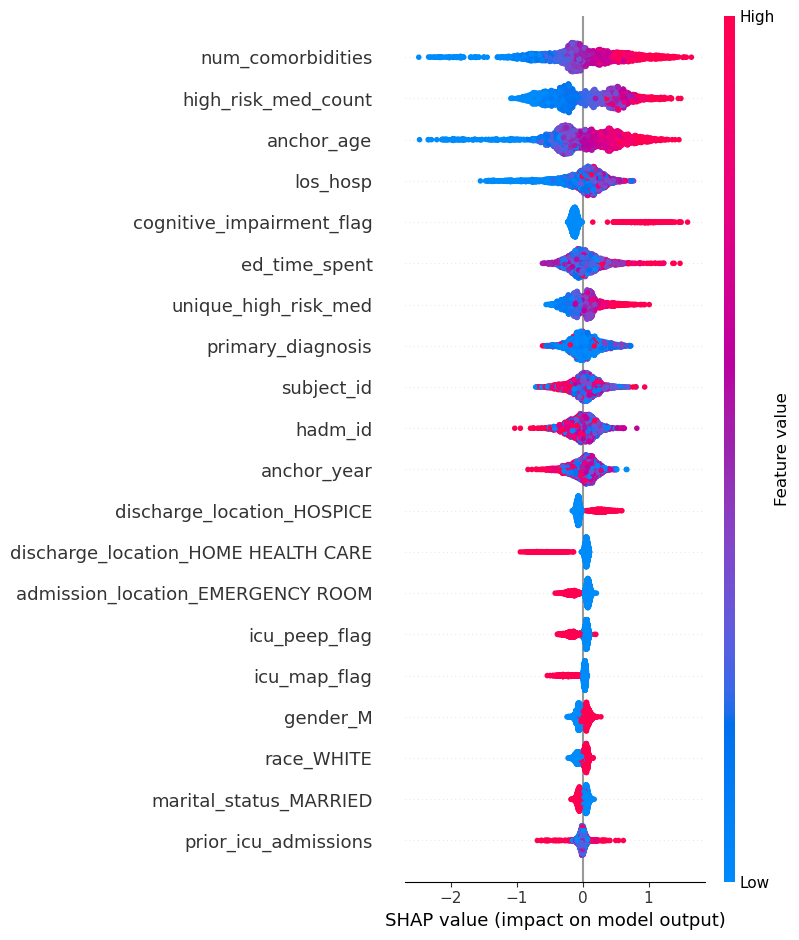


Top 20 Most Important Features Based on SHAP:
num_comorbidities                      0.446022
high_risk_med_count                    0.441007
anchor_age                             0.412125
los_hosp                               0.248736
cognitive_impairment_flag              0.232710
ed_time_spent                          0.175190
unique_high_risk_med                   0.172305
primary_diagnosis                      0.160668
subject_id                             0.156950
hadm_id                                0.153963
anchor_year                            0.144957
discharge_location_HOSPICE             0.124469
discharge_location_HOME HEALTH CARE    0.105625
admission_location_EMERGENCY ROOM      0.105582
icu_peep_flag                          0.094443
icu_map_flag                           0.076651
gender_M                               0.063438
race_WHITE                             0.060057
marital_status_MARRIED                 0.055014
prior_icu_admissions                   0.

In [39]:
#Compute SHAP Feature Importance for XGBoost
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.Explainer(xgb_refined_v2, X_test_scaled_refined_v2)
shap_values = explainer(X_test_scaled_refined_v2)

# Create a DataFrame of SHAP values
shap_df = pd.DataFrame(shap_values.values, columns=X_refined_v2.columns)

# Compute mean absolute SHAP values to rank feature importance
shap_importance = shap_df.abs().mean().sort_values(ascending=False)

# Plot SHAP Summary Plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test_scaled_refined_v2, feature_names=X_refined_v2.columns)

# Print Most Important Features
print("\nTop 20 Most Important Features Based on SHAP:")
print(shap_importance.head(20))

# Print Least Important Features
print("\nBottom 20 Least Important Features Based on SHAP:")
print(shap_importance.tail(20))


SHAP (SHapley Additive exPlanations) is a versatile tool that can be applied to various machine learning models to interpret feature importance. Here's how SHAP interacts with different models:

**1. Logistic Regression:**
- **Applicability:** SHAP can be used with logistic regression models to provide insights into feature contributions.
- **Interpretation:** While logistic regression coefficients indicate the direction and magnitude of feature effects, SHAP values offer a unified measure of feature importance, considering feature interactions and providing both global and local interpretability. citeturn0search3

**2. Random Forest:**
- **Applicability:** SHAP is well-suited for interpreting complex models like random forests.
- **Interpretation:** Traditional feature importance in random forests measures the average impact of features on model predictions. SHAP values, however, provide a more nuanced view by considering feature interactions and offering consistent and locally accurate importance measures. citeturn0search3

**3. XGBoost:**
- **Applicability:** SHAP integrates seamlessly with gradient boosting models like XGBoost.
- **Interpretation:** SHAP values help in understanding the contribution of each feature to individual predictions, making the model's decisions more transparent.

**Applying SHAP for Feature Selection:**
Utilizing SHAP values can enhance feature selection by identifying and potentially removing features with low importance, thereby simplifying the model without significant loss in performance.

**Next Steps:**
- **Compute SHAP Values for Logistic Regression and Random Forest Models:**
  - **Logistic Regression:** Calculate SHAP values to understand feature contributions beyond what coefficients reveal.
  - **Random Forest:** Use SHAP to gain insights into feature importance, considering interactions and non-linear effects.

- **Refine Feature Selection:**
  - Based on SHAP insights, consider removing features with consistently low importance across models to enhance model efficiency and interpretability.

By integrating SHAP analyses across different models, we can achieve a comprehensive understanding of feature impacts, leading to more informed decisions in model refinement and deployment. 

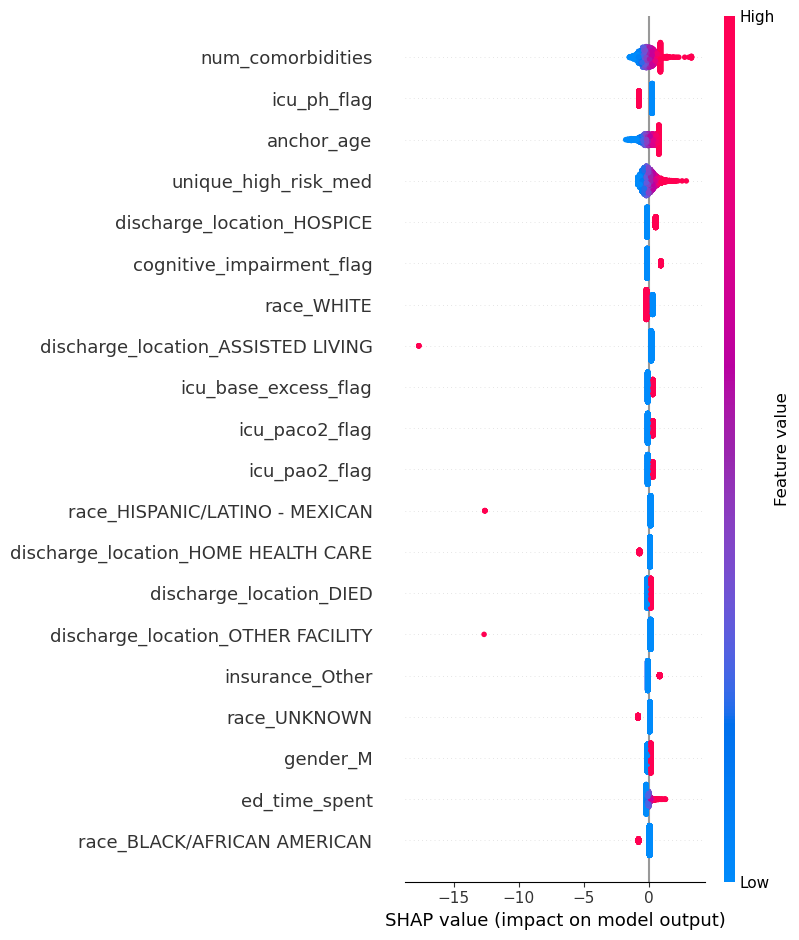


Least Important Features Based on SHAP (Logistic Regression):
race_WHITE - EASTERN EUROPEAN                   0.003892
admission_location_PROCEDURE SITE               0.003769
LabH_WBC_flag                                   0.003368
race_BLACK/AFRICAN                              0.002416
race_SOUTH AMERICAN                             0.002220
race_WHITE - BRAZILIAN                          0.002020
admission_location_INFORMATION NOT AVAILABLE    0.001827
LabH_Hb_flag                                    0.001630
admission_type_OBSERVATION ADMIT                0.001592
admission_type_EU OBSERVATION                   0.001150
admission_type_DIRECT OBSERVATION               0.001123
race_HISPANIC/LATINO - HONDURAN                 0.001057
race_PATIENT DECLINED TO ANSWER                 0.000923
admission_location_PACU                         0.000503
race_HISPANIC/LATINO - SALVADORAN               0.000475
race_HISPANIC/LATINO - CENTRAL AMERICAN         0.000176
icu_iabp_flag            

100%|===================| 5149/5154 [08:23<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.765670, while the model output was 0.757231. If this difference is acceptable you can set check_additivity=False to disable this check.

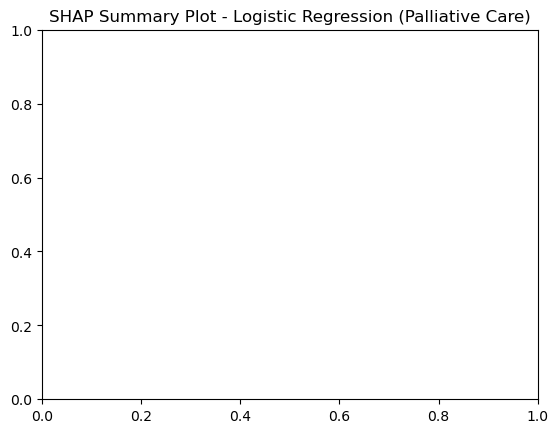

In [41]:
#Compute SHAP for Logistic Regression and Random Forest
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize SHAP Explainer for Logistic Regression
explainer_lr = shap.Explainer(lr_smote, X_test_scaled)
shap_values_lr = explainer_lr(X_test_scaled)

# Create DataFrame for SHAP values (Logistic Regression)
shap_df_lr = pd.DataFrame(shap_values_lr.values, columns=X.columns)

# Compute mean absolute SHAP values for feature importance
shap_importance_lr = shap_df_lr.abs().mean().sort_values(ascending=False)

# Plot SHAP Summary for Logistic Regression
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_lr, X_test_scaled, feature_names=X.columns)
plt.title("SHAP Summary Plot - Logistic Regression (Palliative Care)")

# Display Least Important Features for Logistic Regression
print("\nLeast Important Features Based on SHAP (Logistic Regression):")
print(shap_importance_lr.tail(20))

# Initialize SHAP Explainer for Random Forest
explainer_rf = shap.Explainer(rf_smote, X_test_scaled)
shap_values_rf = explainer_rf(X_test_scaled)

# Create DataFrame for SHAP values (Random Forest)
shap_df_rf = pd.DataFrame(shap_values_rf.values, columns=X.columns)

# Compute mean absolute SHAP values for feature importance
shap_importance_rf = shap_df_rf.abs().mean().sort_values(ascending=False)

# Plot SHAP Summary for Random Forest
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_rf, X_test_scaled, feature_names=X.columns)
plt.title("SHAP Summary Plot - Random Forest (Palliative Care)")

# Display Least Important Features for Random Forest
print("\nLeast Important Features Based on SHAP (Random Forest):")
print(shap_importance_rf.tail(20))


In [45]:
# Initialize SHAP Explainer for Random Forest
explainer_rf = shap.TreeExplainer(rf_smote, feature_perturbation="tree_path_dependent")

# Compute SHAP values
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# Create DataFrame for SHAP values (Random Forest)
shap_df_rf = pd.DataFrame(shap_values_rf[1], columns=X.columns)  # Use index 1 for class=1 (Delirium)

# Compute mean absolute SHAP values for feature importance
shap_importance_rf = shap_df_rf.abs().mean().sort_values(ascending=False)

# Plot SHAP Summary for Random Forest
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_rf[1], X_test_scaled, feature_names=X.columns)
plt.title("SHAP Summary Plot - Random Forest (Palliative Care)")

# Display Least Important Features for Random Forest
print("\nLeast Important Features Based on SHAP (Random Forest):")
print(shap_importance_rf.tail(20))


ValueError: Shape of passed values is (104, 2), indices imply (104, 104)

In [47]:
# Initialize SHAP Explainer for Random Forest
explainer_rf = shap.TreeExplainer(rf_smote, feature_perturbation="tree_path_dependent")

# Compute SHAP values
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# Ensure SHAP values are extracted correctly for `delirium = 1`
if isinstance(shap_values_rf, list):
    shap_values_rf_class1 = shap_values_rf[1]  # Extract SHAP values for class=1 (Delirium)
else:
    shap_values_rf_class1 = shap_values_rf  # Handle single-class cases

# Create DataFrame for SHAP values (Random Forest)
shap_df_rf = pd.DataFrame(shap_values_rf_class1, columns=X.columns)

# Compute mean absolute SHAP values for feature importance
shap_importance_rf = shap_df_rf.abs().mean().sort_values(ascending=False)

# Plot SHAP Summary for Random Forest
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_rf_class1, X_test_scaled, feature_names=X.columns)
plt.title("SHAP Summary Plot - Random Forest (Palliative Care)")

# Display Least Important Features for Random Forest
print("\nLeast Important Features Based on SHAP (Random Forest):")
print(shap_importance_rf.tail(20))


ValueError: Must pass 2-d input. shape=(2577, 104, 2)

In [49]:
import pandas as pd

# Define the file path
cleaned_file = "D:/MIMIC-IV-Data-Pipeline/processed_data/mimic_cleaned_v8.csv.gz"

# Load the dataset
df = pd.read_csv(cleaned_file, compression="gzip")

print("Cleaned dataset reloaded successfully.")


Cleaned dataset reloaded successfully.


In [51]:
import shap
import numpy as np
import pandas as pd

# Ensure SHAP is properly initialized
explainer = shap.Explainer(xgb_model, X_test_scaled)
shap_values = explainer(X_test_scaled)

# Check SHAP value shape
print(f"SHAP Value Shape: {shap_values.values.shape}")  # This tells us if it's 3D

# Handle case where SHAP outputs 3D array (multi-class case)
if len(shap_values.values.shape) == 3:
    shap_values_class1 = shap_values.values[:, :, 1]  # Take SHAP values for class 1 (delirium)
else:
    shap_values_class1 = shap_values.values  # Directly use the values if already 2D

# Convert to DataFrame
shap_df = pd.DataFrame(shap_values_class1, columns=X.columns)

# Compute mean absolute SHAP values for feature importance
shap_importance = shap_df.abs().mean().sort_values(ascending=False)

# Display top features
print("Top 10 SHAP Feature Importances:")
print(shap_importance.head(10))


 96%|=================== | 2475/2577 [00:15<00:00]       

SHAP Value Shape: (2577, 104)
Top 10 SHAP Feature Importances:
high_risk_med_count                    0.441694
num_comorbidities                      0.432856
anchor_age                             0.367962
los_hosp                               0.256366
cognitive_impairment_flag              0.164384
hadm_id                                0.153257
discharge_location_HOME HEALTH CARE    0.127070
primary_diagnosis                      0.112506
admission_location_EMERGENCY ROOM      0.109225
subject_id                             0.103237
dtype: float64
